
##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [0]:
# Copyright 2019 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# DDSP ProcessorGroup Demo

This notebook demonstrates the use of a `ProcessorGroup()` as an alternative to stringing signal `Processors()` together in python. 

The main advantage of using a ProcessorGroup is that the entire signal processing chain can be specified in a `.gin` file, as a Directed Acyclic Graph (DAG), removing the need to write code in python for every configuration of processors.


# Imports

In this tutorial we're going to synthesize some audio from these example controls in three different ways.

* With processors and python control flow
* With a ProcessorGroup DAG (via list)
* With a ProcessorGroup DAG (via gin)


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from colabtools import sound
import ddsp 
import gin
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf

# Helper Functions 
sess = tf.compat.v1.InteractiveSession()
sample_rate = 16000
play = lambda x: sound.Play(x, sample_rate)

def f32(tensor):
  return tf.convert_to_tensor(tensor, dtype=tf.float32)

def specplot(audio, vmin=-5, vmax=1, rotate=True, size=512 + 256):
  logmag = ddsp.spectral_ops.calc_logmag(f32(audio), size=size).eval()
  if rotate:
    logmag = np.rot90(logmag)
  plt.matshow(logmag, vmin=vmin, vmax=vmax, cmap=plt.cm.magma, aspect='auto')
  plt.xticks([])
  plt.yticks([])

Example control inputs

In [0]:
# Constants
n_frames = 1000
hop_size = 64
n_samples = n_frames * hop_size


#### Additive controls
# Amplitude [batch, n_frames, 1].
amps = np.linspace(0.5, -5.0, n_frames)[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
n_harmonics = 20
harmonic_distribution = np.ones([n_frames, 1]) * np.linspace(1.0, -1.0, n_harmonics)[np.newaxis, :]
for i in range(n_harmonics):
  harmonic_distribution[:, i] = 1.0 - np.linspace(i * 0.09, 2.0, 1000)
  if i % 2 != 0:
    harmonic_distribution[:, i] = -3
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = np.linspace(300.0, 200.0, n_frames)[np.newaxis, :, np.newaxis]


### Filtered Noise controls
# Magnitudes [batch, n_frames, n_magnitudes].
n_filter_banks = 20
magnitudes = np.linspace(0.0, -3.0, n_filter_banks)[np.newaxis, np.newaxis, :]
magnitudes = magnitudes + amps 


### Reverb controls
n_fade_in = 16 * 10
ir_size = int(sample_rate * 2)
n_fade_out = ir_size - n_fade_in

ir = 0.01 * np.random.randn(ir_size)
ir[:n_fade_in] *= np.linspace(0.0, 1.0, n_fade_in)
ir[n_fade_in:] *= np.exp(np.linspace(0.0, -5.0, n_fade_out))
ir = ir[np.newaxis, :]


inputs = {
    'amps': f32(amps),
    'harmonic_distribution': f32(harmonic_distribution),
    'f0_hz': f32(f0_hz),
    'magnitudes': f32(magnitudes),
    'ir': f32(ir),
}

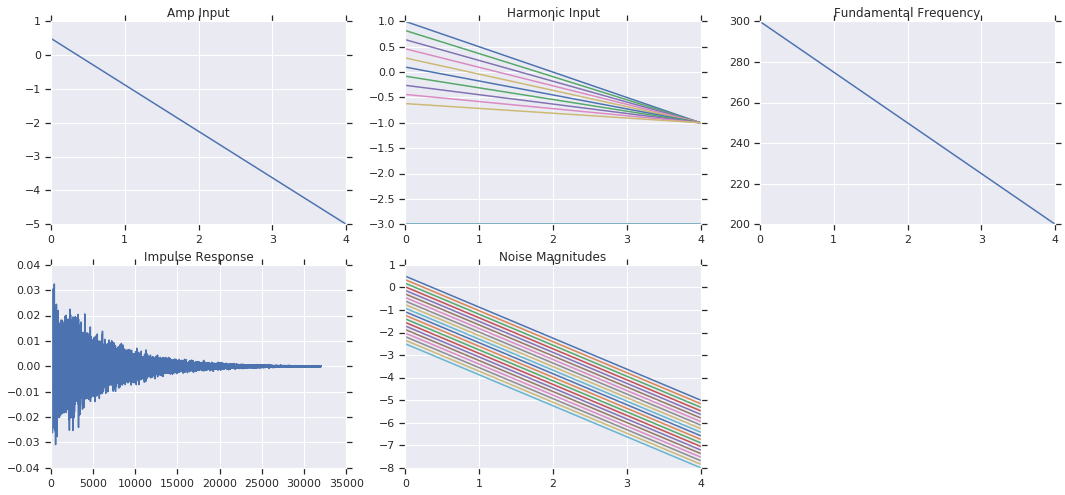

In [0]:
# Plot the inputs
time = np.linspace(0, n_samples / sample_rate, n_frames)

plt.figure(figsize=(18, 8))
plt.subplot(231)
plt.plot(time, amps[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Amp Input')

plt.subplot(232)
plt.plot(time, harmonic_distribution[0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Harmonic Input')

plt.subplot(233)
plt.plot(time, f0_hz[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Fundamental Frequency')

plt.subplot(234)
plt.plot(ir[0])
plt.title('Impulse Response')

plt.subplot(235)
plt.plot(time, magnitudes[0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Noise Magnitudes')


# Processors

You can generate signal by stringing Processors together in python, as you would with any other differentiable modules.

In [0]:
additive = ddsp.synths.Additive(n_samples=n_samples)
noise = ddsp.synths.FilteredNoise(n_samples=n_samples)
reverb = ddsp.effects.Reverb()

In [0]:
# Python signal processor chain
audio_additive = additive(inputs['amps'],
                          inputs['harmonic_distribution'],
                          inputs['f0_hz'])
audio_noise = noise(inputs['magnitudes'])
audio_dry = audio_additive + audio_noise
audio_out = reverb(inputs['ir'], audio_dry)

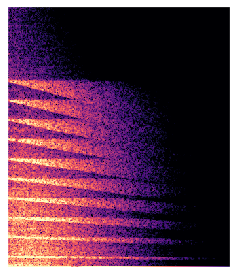

In [0]:
# Play the audio
audio_np = audio_out.eval()[0, :]
play(audio_np)
specplot(audio_np)

# ProcessorGroup

A ProcessorGroup is a Directed Acycic Graph (DAG) of Processors.

You can specify the DAG as a list of tuples `dag = [(processor, ['input1', 'input2', ...]), ...]`

The ProcessorGroup takes a dictionary of inputs, whose keys are referenced as inputs in the DAG.

The output signal of each processor can be referenced as an input by the string `'processor_name/signal'` where processor_name is the name of the processor at construction.


In [0]:
print(inputs.keys())

['magnitudes', 'amps', 'ir', 'f0_hz', 'harmonic_distribution']


In [0]:
additive = ddsp.synths.Additive(n_samples=n_samples, name='additive')
noise = ddsp.synths.FilteredNoise(n_samples=n_samples, name='noise')
reverb = ddsp.effects.Reverb(name='reverb')
add = ddsp.processors.Add(name='add')

In [0]:
# Processor group DAG

dag = [
  (additive, ['amps', 'harmonic_distribution', 'f0_hz']),
  (noise, ['magnitudes']),
  (add, ['additive/signal', 'noise/signal']),
  (reverb, ['ir', 'add/signal'])
]

processor_group = ddsp.processors.ProcessorGroup(dag=dag)
audio_out = processor_group.get_signal(inputs)

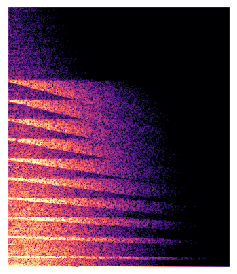

In [0]:
# Play the audio
audio_np = audio_out.eval()[0, :]
play(audio_np)
specplot(audio_np)

The processor group also offers all the intermediate signals and control tensors for inspection.

In [0]:
outputs = processor_group.get_outputs(inputs)

for k, v in outputs.items():
  print(k, v)

ir Tensor("Const_22:0", shape=(1, 32000), dtype=float32)
processor_group {'signal': <tf.Tensor 'strided_slice_186:0' shape=(1, 64000) dtype=float32>}
reverb {'controls': {'impulse_response': <tf.Tensor 'Const_22:0' shape=(1, 32000) dtype=float32>, 'input_audio': <tf.Tensor 'add_77:0' shape=(1, 64000) dtype=float32>}, 'signal': <tf.Tensor 'strided_slice_186:0' shape=(1, 64000) dtype=float32>}
add {'controls': {'signal_one': <tf.Tensor 'Sum_33:0' shape=(1, 64000) dtype=float32>, 'signal_two': <tf.Tensor 'strided_slice_184:0' shape=(1, 64000) dtype=float32>}, 'signal': <tf.Tensor 'add_77:0' shape=(1, 64000) dtype=float32>}
f0_hz Tensor("Const_20:0", shape=(1, 1000, 1), dtype=float32)
harmonic_distribution Tensor("Const_19:0", shape=(1, 1000, 20), dtype=float32)
magnitudes Tensor("Const_21:0", shape=(1, 1000, 20), dtype=float32)
additive {'controls': {'f0_hz': <tf.Tensor 'Const_20:0' shape=(1, 1000, 1) dtype=float32>, 'amplitudes': <tf.Tensor 'add_74:0' shape=(1, 1000, 1) dtype=float32>, '

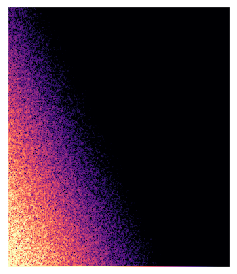

In [0]:
noise_audio = outputs['noise']['signal']
noise_audio_np = noise_audio.eval()[0, :]
play(noise_audio_np)
specplot(noise_audio_np)

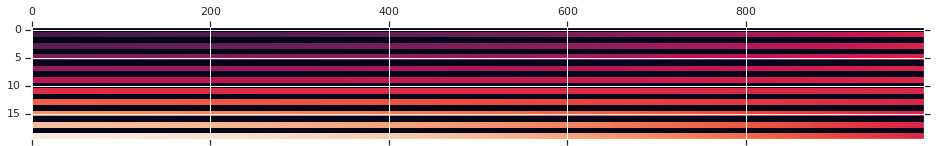

In [0]:
harmonic_distribution_np = outputs['additive']['controls']['harmonic_distribution'].eval()
plt.matshow(np.rot90(harmonic_distribution_np[0, :, :]), aspect='auto')

# Configuration with Gin

The main advantage of a ProcessorGroup is that it can be defined with Gin, allowing flexible configurations without having to write new python code for every DAG of processors.

In the example below we pretend we have an external file written, which we treat here as a string.

In [0]:
gin_file_string = """
import ddsp

processors.ProcessorGroup.dag = [
  (@Additive(), ['amps', 'harmonic_distribution', 'f0_hz']),
  (@FilteredNoise(), ['magnitudes']),
  (@Add(), ['noise/signal', 'additive/signal']),
  (@Reverb(), ['ir', 'add/signal'])
]

Additive.name = 'additive'
FilteredNoise.name = 'noise'
Add.name = 'add'

Additive.n_samples = 64000
FilteredNoise.n_samples = 64000
"""
with gin.unlock_config():
  gin.parse_config(gin_file_string)

Now, after parsing the gin file, the ProcessorGroup will be configured on construction.

In [0]:
processor_group = ddsp.processors.ProcessorGroup()
audio_out = processor_group.get_signal(inputs)

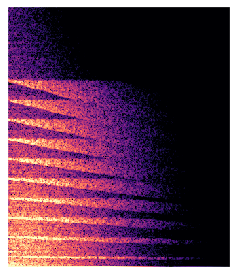

In [0]:
# Play the audio
audio_np = audio_out.eval()[0, :]
play(audio_np)
specplot(audio_np)